In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [171]:
columns = ['HHI','HHDL','Married','CollegGrads','AHHAge','Cars','Filed in 2017','Filed in 2016', 'Filed in 2015','PoliticalParty']
columns_2 = ['HHI','HHDL','Married','CollegGrads','AHHAge','Cars','Filed in 2017','Filed in 2016', 'Filed in 2015']

In [172]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/tax_payers/train_set_label.csv",usecols=columns)
df_submission = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/tax_payers/test_set_label.csv',usecols=columns_2)
df.head()

,HHI,HHDL,Married,CollegGrads,AHHAge,Cars,Filed in 2017,Filed in 2016,Filed in 2015,PoliticalParty
0,183414,-12402,1,2,28,1,0,0,1,Democrat
1,129786,700251,2,5,63,3,0,0,0,Republican
2,268343,493411,2,4,44,1,1,0,1,Independent
3,290506,-433408,1,1,28,5,1,0,1,Republican
4,90108,907135,1,3,57,5,1,1,0,Democrat


In [173]:
df.PoliticalParty.nunique()

3

In [174]:
df.isnull().sum()

HHI               0
HHDL              0
Married           0
CollegGrads       0
AHHAge            0
Cars              0
Filed in 2017     0
Filed in 2016     0
Filed in 2015     0
PoliticalParty    0
dtype: int64

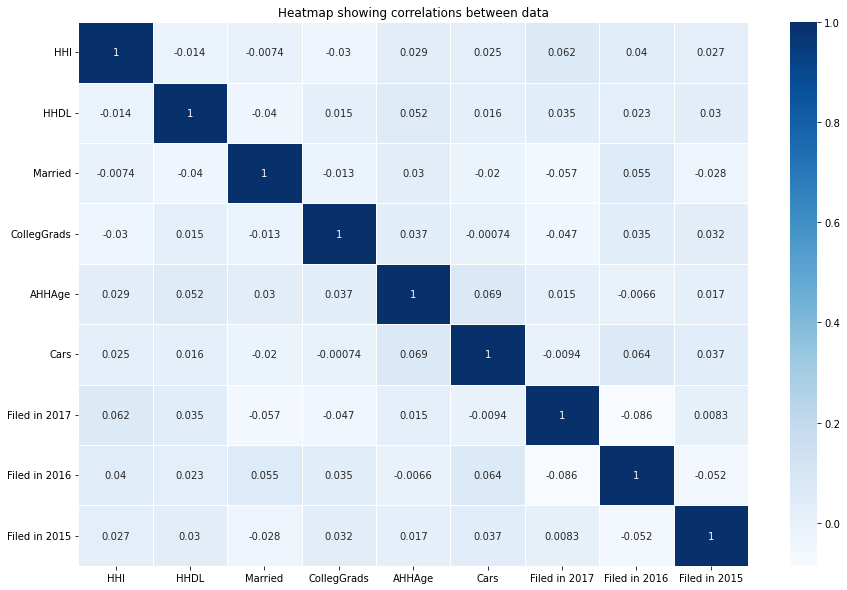

In [175]:
plt.figure(figsize=(15,10))  
sns.heatmap(df.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between data')
plt.show()

In [176]:
df.corr().unstack().sort_values(ascending = False)

HHI            HHI              1.000000
HHDL           HHDL             1.000000
Filed in 2016  Filed in 2016    1.000000
Filed in 2017  Filed in 2017    1.000000
Cars           Cars             1.000000
                                  ...   
Filed in 2015  Filed in 2016   -0.051725
Filed in 2017  Married         -0.056867
Married        Filed in 2017   -0.056867
Filed in 2016  Filed in 2017   -0.086207
Filed in 2017  Filed in 2016   -0.086207
Length: 81, dtype: float64

In [177]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.PoliticalParty
y_val = df_val.PoliticalParty
y_test = df_test.PoliticalParty

del df_train['PoliticalParty']
del df_val['PoliticalParty']
del df_test['PoliticalParty']

In [178]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

scores = []
depths = [10, 15, 20, 25, 50, 100]

for d in depths:
    dt = DecisionTreeClassifier(max_depth = d, random_state=1)
    dt.fit(df_train, y_train)
    y_pred = dt.predict(df_val)
    score = accuracy_score(y_val, y_pred) * 100
    scores.append((d,score))

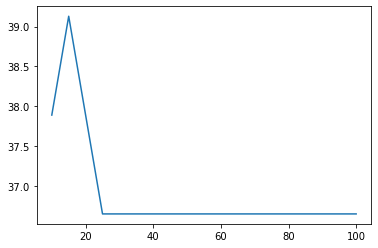

In [179]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'accuracy'])
plt.plot(df_scores.max_depth, df_scores.accuracy)

In [180]:
from sklearn.ensemble import RandomForestClassifier
scores = []
ns = [10, 20, 30, 40, 50, 100]

for n in ns:
    rf = RandomForestClassifier(n_estimators = n, random_state = 1, n_jobs = -1)
    rf.fit(df_train, y_train)
    y_pred = rf.predict(df_val)
    score = accuracy_score(y_val, y_pred) * 100
    scores.append((n,score))

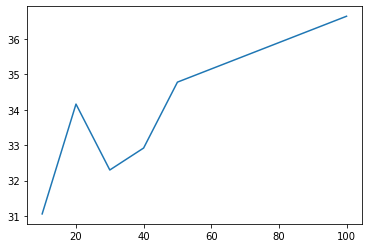

In [181]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [182]:
scores = []
depths = [10, 15, 20, 25, 50, 100]
n = 100

for d in depths:
    rf = RandomForestClassifier(n_estimators = n, max_depth = d, random_state = 1, n_jobs = -1)
    rf.fit(df_train, y_train)
    y_pred = rf.predict(df_val)
    score = accuracy_score(y_val, y_pred) * 100
    scores.append((d,score))

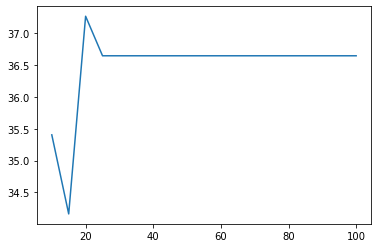

In [183]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'rmse'])
plt.plot(df_scores.max_depth, df_scores.rmse)

In [184]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 20, random_state = 1, n_jobs = -1)
rf.fit(df_train, y_train)
y_pred = rf.predict(df_test)
rfscore = accuracy_score(y_test, y_pred) * 100

In [185]:
dt = DecisionTreeClassifier(max_depth = d, random_state=1)
dt.fit(df_train, y_train)
y_pred = dt.predict(df_test)
dtscore = accuracy_score(y_test, y_pred) * 100

In [186]:
def label_to_int(label):
    if label == 'Democrat':
        return 1
    elif label == 'Republican':
        return 2
    else:
        return 0

y_train  = y_train.apply(label_to_int)
y_val = y_val.apply(label_to_int)
y_test = y_test.apply(label_to_int)
y_train


0      1
1      1
2      2
3      0
4      2
      ..
476    0
477    1
478    0
479    1
480    2
Name: PoliticalParty, Length: 481, dtype: int64

In [187]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(df_train,y_train)
y_pred = xgb_cl.predict(df_val)
xgb_score = accuracy_score(y_val, y_pred)

In [188]:
import lightgbm as lgb
lgb_cl = lgb.LGBMClassifier()
lgb_cl.fit(df_train,y_train)
y_pred = lgb_cl.predict(df_test)
lgb_score = accuracy_score(y_test, y_pred)

In [189]:
[xgb_score, lgb_score, dtscore,rfscore]

[0.38509316770186336,
 0.32919254658385094,
 33.54037267080746,
 36.64596273291926]

In [190]:
df_submission

,HHI,HHDL,Married,CollegGrads,AHHAge,Cars,Filed in 2017,Filed in 2016,Filed in 2015
0,253274,-633752,2,1,94,3,0,1,1
1,47107,322850,0,1,30,2,1,1,0
2,111874,300583,0,2,46,3,0,1,1
3,96670,107419,0,3,77,5,0,0,0
4,128669,341273,0,0,92,4,1,1,1
...,...,...,...,...,...,...,...,...,...
196,138204,144986,1,1,63,1,1,1,0
197,73250,-810927,0,5,40,1,1,0,1
198,134376,352116,0,2,86,1,1,0,0
199,70820,260337,0,3,78,3,1,0,1


In [191]:
xgb_pred = xgb_cl.predict(df_submission)

In [192]:
def reverse_label(label):
    if label == 1:
        return 'Democrat'
    elif label == 2:
        return 'Republican'
    else:
        return 'Independent'

In [193]:
submission = pd.Series(xgb_pred, name='prediction')
submission = submission.apply(reverse_label).reset_index(drop=True)

In [194]:
submission = pd.DataFrame({'prediction': submission})
submission.to_csv('submission.csv', index=False)